In [1]:
import os

from PIL import Image
import numpy as np
import pandas as pd

import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Import matplotlib for visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


## Hyperparameter

In [2]:
BATCH_SIZE = 32
epochs= 15
device= 'cuda' if torch.cuda.is_available() else 'cpu'
train_path='/kaggle/input/intel-image-classification/seg_train/seg_train'
test_path='/kaggle/input/intel-image-classification/seg_test/seg_test'

## Data Exploration

In [3]:
train_directories=os.listdir(train_path)
train_directories

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [4]:
total = 0
train = []

# Header
print("Directory".ljust(20) + "Images Count")
print("-" * 35)

# Iterating through directories
for file_name in train_directories:
    dir_path = os.path.join(train_path, file_name)
    image_count = len(os.listdir(dir_path))
    
    # Print formatted output for each directory
    print(f"{file_name.capitalize().ljust(20)}{str(image_count).rjust(10)}")
    
    # Update total and collect image paths
    total += image_count
    for image in os.listdir(dir_path):
        path = os.path.join(dir_path, image)
        train.append([path, file_name])

# Print total count of images
print("-" * 35)
print(f"{'Total test images'.ljust(20)}{str(total).rjust(10)}")
print(f"Length of test list: {len(train)}")


Directory           Images Count
-----------------------------------
Mountain                  2512
Street                    2382
Buildings                 2191
Sea                       2274
Forest                    2271
Glacier                   2404
-----------------------------------
Total test images        14034
Length of test list: 14034


In [5]:
test_directories = os.listdir(test_path)
test_directories

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [6]:
total = 0
test = []

# Header
print("Directory".ljust(20) + "Images Count")
print("-" * 35)

# Iterating through directories
for file_name in test_directories:
    dir_path = os.path.join(test_path, file_name)
    image_count = len(os.listdir(dir_path))
    
    # Print formatted output for each directory
    print(f"{file_name.capitalize().ljust(20)}{str(image_count).rjust(10)}")
    
    # Update total and collect image paths
    total += image_count
    for image in os.listdir(dir_path):
        path = os.path.join(dir_path, image)
        test.append([path, file_name])

# Print total count of images
print("-" * 35)
print(f"{'Total test images'.ljust(20)}{str(total).rjust(10)}")
print(f"Length of test list: {len(test)}")


Directory           Images Count
-----------------------------------
Mountain                   525
Street                     501
Buildings                  437
Sea                        510
Forest                     474
Glacier                    553
-----------------------------------
Total test images         3000
Length of test list: 3000


## Building the Dataloader

In [7]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [59]:
class CustomDataset(Dataset):
    def __init__(self , paths , transform = None ):
        
        self.paths = paths
        self.transform = transform
        self.labels = [int(class_labels[path[1]]) for path in paths]
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        
        img = Image.open(self.paths[index][0])
        #label = int(class_labels[self.paths[index][1]])
        label = self.labels[index]
        
        if self.transform:
            img = self.transform(img)
           
        return img , label

   

In [60]:
train_data = CustomDataset(paths=train, transform=transform)
test_data  = CustomDataset(paths=test, transform=transform)

In [61]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
train_features_batch, train_labels_batch= next(iter(train_loader))


(-0.5, 223.5, 223.5, -0.5)

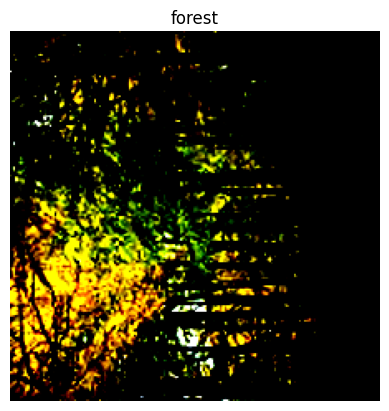

In [13]:
# torch.manual_seed(69)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
img=img.permute(2,1,0)
plt.imshow(img)
plt.title(class_names[label])
plt.axis('off')

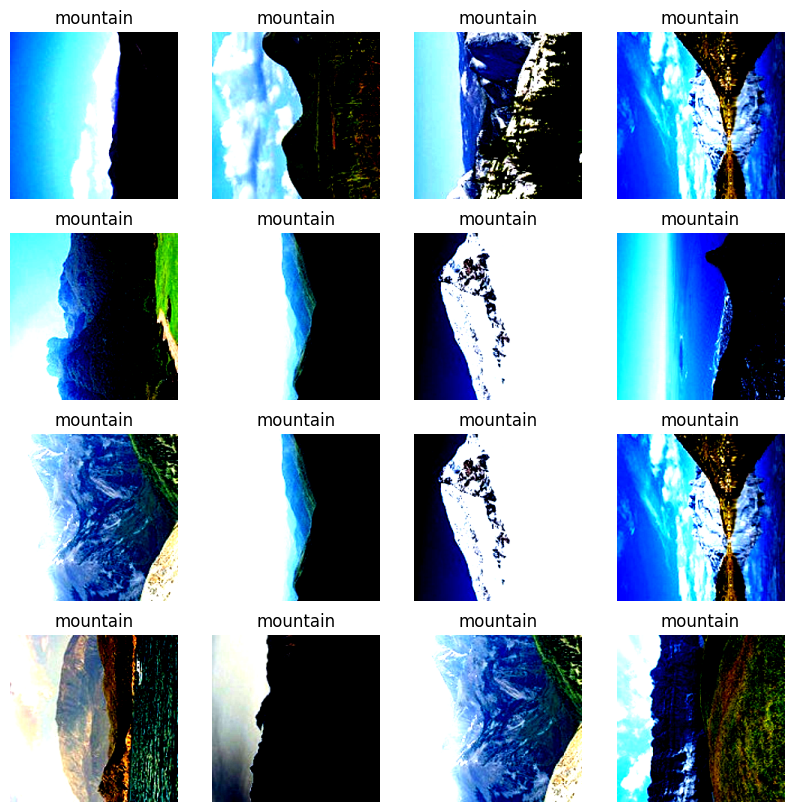

In [14]:
fig=plt.figure(figsize=(10,10))
rows, cols= 4,4
for i in range(1, rows*cols+1):
    random_idx=torch.randint(0,len(train_features_batch),size=[1]).item() #torch.randint(low, high, size)
    img,label= train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    img=img.permute(2,1,0)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis(False)

# Build the base model

In [15]:
# class ImageClassifyModelV0(nn.Module):
#     def __init__(self,input_shape:int, hidden_units:int, output_shape:int):
#         super().__init__() 
#         self.block1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(3,2)
#         )
#         self.block2 = nn.Sequential(
#             nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_units, hidden_units,kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(3,2)    
#         )
#         self.classifier= nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=hidden_units*56*56,
#                       out_features=hidden_units),
#             nn.Linear(in_features=hidden_units,
#                       out_features=output_shape)
#         )
#     def forward(self,x):
#         x = self.block1(x)
#         #print(x.shape)
#         x = self.block2(x)
#         #print(x.shape)
#         x = self.classifier(x)
#         #print(x.shape)
#         return x

In [16]:
import torch.nn as nn

class ImageClassifyModelV0(nn.Module):
    def __init__(self):
        super(ImageClassifyModelV0, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Adjust input channels as needed
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(93312, 512),  # Adjust input features based on your input size
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # Adjust output size based on number of classes
        )
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.classifier(out)
        
        return out


In [17]:
model00= ImageClassifyModelV0()
model00

ImageClassifyModelV0(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=93312, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512

In [ ]:
# model0 = ImageClassifyModelV0(input_shape=3, hidden_units=256, output_shape=len(class_labels))
# model0
# model0 = ImageClassifyModelV0(input_shape = 3,
#                               hidden_units = 10,
#                               output_shape =10)

In [19]:
dummy = torch.randn(size=(3,224,224))

In [20]:
dummy.shape

torch.Size([3, 224, 224])

In [21]:
model00(dummy.unsqueeze(0))

tensor([[ 0.0338,  0.0666,  0.0590, -0.0461,  0.0560,  0.0217,  0.0429,  0.0242,
          0.0384,  0.0557]], grad_fn=<AddmmBackward0>)

In [22]:
# set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model00.parameters(), lr=0.1)

## Traning and testing loop

In [23]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
def train_step(data_loader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    

In [25]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [81]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X=X.to(device)
            y=y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [82]:
model_2_results= eval_model(
    model=model00,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

In [83]:
model_2_results

{'model_name': 'ImageClassifyModelV0',
 'model_loss': 1.055138111114502,
 'model_acc': 78.63475177304964}

In [ ]:
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model00, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader,
        model=model00,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

In [34]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [36]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 2 (glacier)


In [78]:
# Make predictions on test samples with model 
pred_probs= make_predictions(model=model00, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.1391e-07, 1.9223e-11, 1.0000e+00, 1.7172e-06, 8.4036e-09, 3.8921e-08,
         9.1728e-12, 5.3392e-12, 3.3019e-12, 1.1818e-11],
        [8.2214e-07, 1.9794e-07, 1.5065e-06, 9.9994e-01, 5.7590e-05, 3.4977e-10,
         1.7906e-12, 2.3214e-12, 3.7117e-12, 8.9061e-12]])

In [79]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 3, 3, 0, 5, 5, 5, 2, 2])

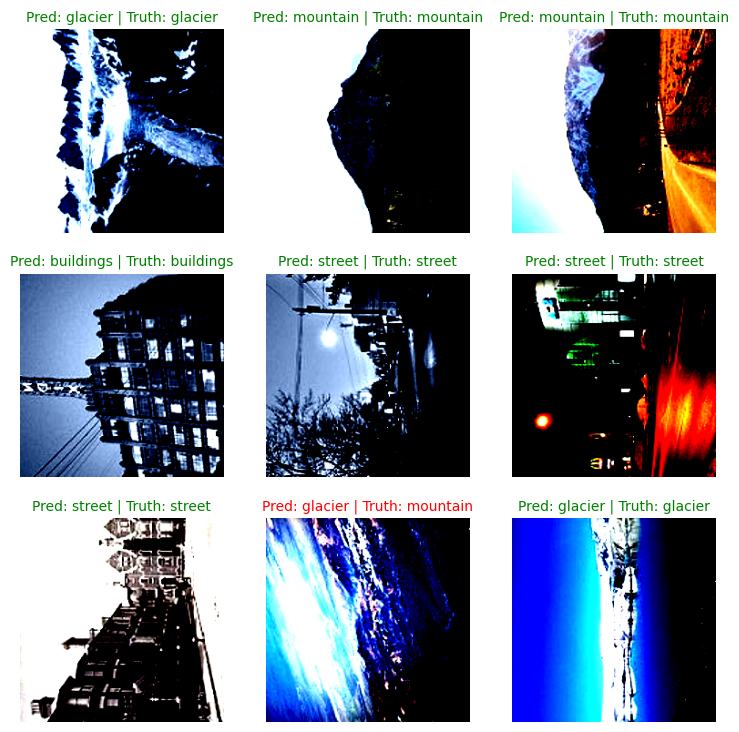

In [80]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    
# Create a subplot
  sample= sample.permute(2,1,0)
  plt.subplot(nrows, ncols, i+1)
  # Plot the target image
  plt.imshow(sample, cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);
    
      

In [48]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model00.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model00(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/94 [00:00<?, ?it/s]

In [49]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [66]:
# import torch

# # Assuming y_pred_tensor is currently a list or numpy array
# y_pred_tensor = torch.tensor(y_pred_tensor)  # Convert to tensor if not already

# # Ensure test_data.labels is also a tensor
# all_labels = [label for _, label in test_data]  # Get all labels as a list
# target_tensor = torch.tensor(all_labels)  # Convert list to tensor

# # Now pass these tensors to the confusion matrix
# confmat_tensor = confmat(preds=y_pred_tensor, target=target_tensor)


/tmp/ipykernel_30/1671059818.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred_tensor)  # Convert to tensor if not already


/tmp/ipykernel_30/756739701.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred_tensor)  # Ensure predictions are a tensor


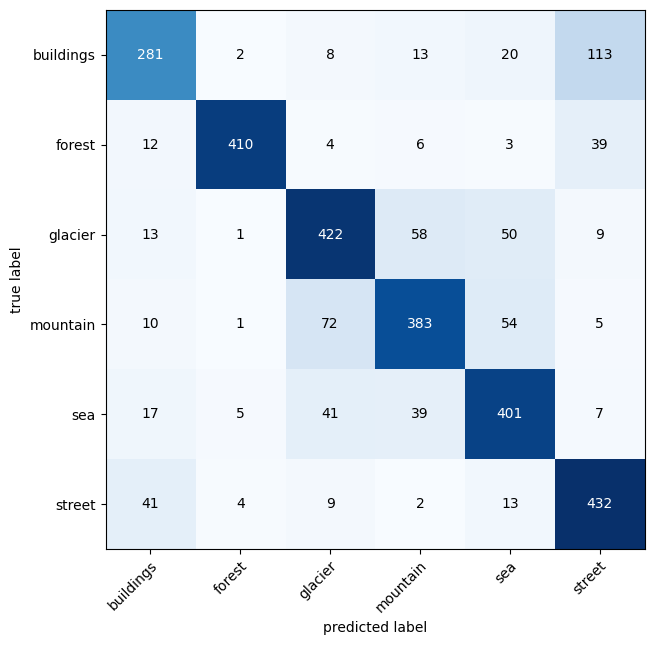

In [68]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# Convert predictions and targets to tensors if they are not already
y_pred_tensor = torch.tensor(y_pred_tensor)  # Ensure predictions are a tensor
all_labels = [label for _, label in test_data]  # Get all labels as a list
target_tensor = torch.tensor(all_labels)  # Convert list to tensor

# Update confusion matrix
confmat_tensor = confmat(preds=y_pred_tensor, target=target_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Convert to numpy for plotting
    class_names=class_names,           # Class names for labels
    figsize=(10, 7)
);


In [70]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model00.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor